전력 데이터 활용한 데이터 분석

In [ ]:
# ========== 청주 API =========
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
from tqdm import tqdm
import requests

# 기상청 API URL 및 서비스키
url = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList'
key = '''pW/c+2CniRj2GyKAOpzTmuVxZWy9u814f/XpHKas7B/IePSALTsBgSDmLeCIp5hf3TZ3QnsHT4XeNB9hHHNlwA=='''

# 청주 지역 코드
station_id = '131'  # 청주 기상대의 ASOS 코드

# 날짜 범위 (2021년 10월 20일부터 2021년 10월 30일까지)
start_end_date = [
    ('20211020', '20211030')  # 2021년 10월 20일부터 10월 30일까지
]

dfs = []
for i in tqdm(start_end_date):
    print(f"Fetching data from {i[0]} to {i[1]}")

    params = {
        'serviceKey': key,  # API 키
        'pageNo': '1',  # 페이지 번호
        'numOfRows': '999',  # 한 번에 가져올 최대 행 수
        'dataType': 'JSON',  # 데이터 형식 (JSON)
        'dataCd': 'ASOS',  # 자료분류코드 (ASOS)
        'dateCd': 'HR',  # 날짜분류코드 (시간별)
        'startDt': i[0],  # 시작일 (YYYYMMDD)
        'startHh': '00',  # 시작시간
        'endDt': i[1],  # 종료일 (YYYYMMDD)
        'endHh': '23',  # 종료시간
        'stnIds': station_id  # 청주 기상대 코드
    }

    # 요청 보내기
    response = requests.get(url, params=params, verify=False)
    result = response.json()

    # JSON 데이터를 DataFrame으로 변환
    df = pd.DataFrame(result['response']['body']['items']['item'])
    dfs.append(df)

# 여러 기간의 데이터를 하나의 DataFrame으로 합침
final_df = pd.concat(dfs, axis=0, ignore_index=True)

# 결과 확인
print(final_df.head())


final_df.head(5)

final_df.isnull().sum()
final_df.shape

# 모든 값이 NaN인 열을 제거하는 코드
df_cleaned = final_df.dropna(axis=1, how='all')

# NaN 값은 남겨두고, 빈 칸을 NaN으로 변환 (이 과정을 통해 빈 값들을 NaN으로 처리)
df_cleaned.replace('', pd.NA, inplace=True)
df_cleaned

# 두 개의 파일을 불러옵니다.
try:
    file1 = pd.read_csv('/mnt/data/cheongju_clean_weather_data.csv', encoding='utf-8')
except UnicodeDecodeError:
    file1 = pd.read_csv('/mnt/data/cheongju_clean_weather_data.csv', encoding='latin1')

try:
    file2 = pd.read_csv('/mnt/data/61번_MAIN (1).csv', encoding='utf-8')
except UnicodeDecodeError:
    file2 = pd.read_csv('/mnt/data/61번_MAIN (1).csv', encoding='latin1')

# 각 파일의 열 이름 확인
print("File 1 Columns:", file1.columns)
print("File 2 Columns:", file2.columns)

# '일시' 열이 존재하는지 확인
if '일시' in file1.columns and '일시' in file2.columns:
    # '일시' 열을 datetime 형식으로 변환
    file1['일시'] = pd.to_datetime(file1['일시'], errors='coerce')
    file2['일시'] = pd.to_datetime(file2['일시'], errors='coerce')

    # 두 파일을 '일시' 열 기준으로 병합 (inner join: 공통되는 '일시'만 남김)
    merged_df = pd.merge(file1, file2, on='일시', how='inner')

    # 결과를 확인
    print(merged_df.head())

# 컬럼명 변경
file2.rename(columns={'ÀÏ½Ã': 'tm', 'Àü·Â»ç¿ë·®': 'value'}, inplace=True)

# 'date' 열에서 특정 문자열 제거
file2['tm'] = file2['tm'].str.replace('¿ÀÀü', '', regex=False).str.replace('¿ÀÈÄ', '', regex=False).str.strip()

# 'date' 열에서 시간이 없는 경우 '0:00' 추가
file2['tm'] = file2['tm'].apply(lambda x: x + ' 0:00:00' if len(x.split()) == 1 else x)

# CSV 파일로 저장
file2.to_csv('tmclean_61.csv', index=False, encoding='utf-8')

file1['date_time'] = pd.to_datetime(file1['tm'], errors='coerce')
file2['date_time'] = pd.to_datetime(file2['date'], errors='coerce')

# 두 파일을 'date_time' 기준으로 병합 (inner join)
merged_df = pd.merge(file1, file2, on='date_time', how='inner')

# 결과 확인
print(merged_df.head())

merged_df
merged_df.to_csv('merged_output.csv', index=False, encoding='utf-8')

merge = pd.read_csv('/mnt/data/merged_output.csv', encoding='utf-8')
merge['taQcflg'].isna()

# ===================================

data = pd.read_csv('/mnt/data/cheongju_weather_data_20211020_to_20211030.csv', encoding='utf-8')
data.shape
null_counts = data.isnull().sum()
data_cleaned = data.loc[:, null_counts != 264]

data_cleaned.isnull().sum()
data_cleaned.to_csv('/mnt/data/kcheongju_cleaned (1).csv', encoding='utf-8-sig')

file1 = pd.read_csv('/mnt/data/kcheongju_cleaned (1).csv', encoding='utf-8')
file2 = pd.read_csv('/mnt/data/clean_61.csv', encoding='utf-8')

# ===================================

# 두 데이터프레임 가로로 결합
combined_df = pd.concat([file1, file2], axis=1)

# 특정 열 'B' 드롭하기
df_dropped = combined_df.drop(columns=['date'])

# 결합된 데이터를 새로운 CSV 파일로 저장
df_dropped.to_csv('/mnt/data/combined_df.csv', index=False, encoding='utf-8-sig')
df_dropped.shape

df = pd.read_csv('/mnt/data/combined_df.csv', encoding='utf-8-sig')
df

df = df.rename(columns={
    'tm': '시간',
    'stnNm': '지점명',
    'ta': '기온',
    'ws': '풍속',
    'wd': '풍향',
    'hm': '습도',
    'pv': '증기압',
    'td': '이슬점온도',
    'pa': '현지기압',
    'ps': '해면기압',
    'ss': '일조',
    'ssQcflg': '일조 품질검사플래그',
    'icsr': '일사',
    'dc10Tca': '전운량',
    'dc10LmcsCa': '중하층 운량',
    'clfmAbbrCd': '운형',
    'lcsCh': '최저 운고',
    'vs': '시정',
    'dmstMtphNo': '현상번호',
    'ts': '지면온도',
    'value': '전력사용량'
})
df.columns

# 결측치 채우기 (일조/일사)
df['일조'].fillna(0, inplace=True)
df['일사'].fillna(0, inplace=True)

# drop 데이터 drop
columns_to_drop = ['Unnamed: 0', 'rnum','지점명', 'stnId', '일조 품질검사플래그', '현상번호', '최저 운고', '운형', '전운량', '중하층 운량', 'rnQcflg']
df_cleaned = df.drop(columns=columns_to_drop)

final_df = pd.read_csv('/mnt/data/realreal_final_df.csv', encoding='utf-8-sig')
final_df

테스트 셋(2021-10-30)에 대한 SMAPE: 0.027510191476474807


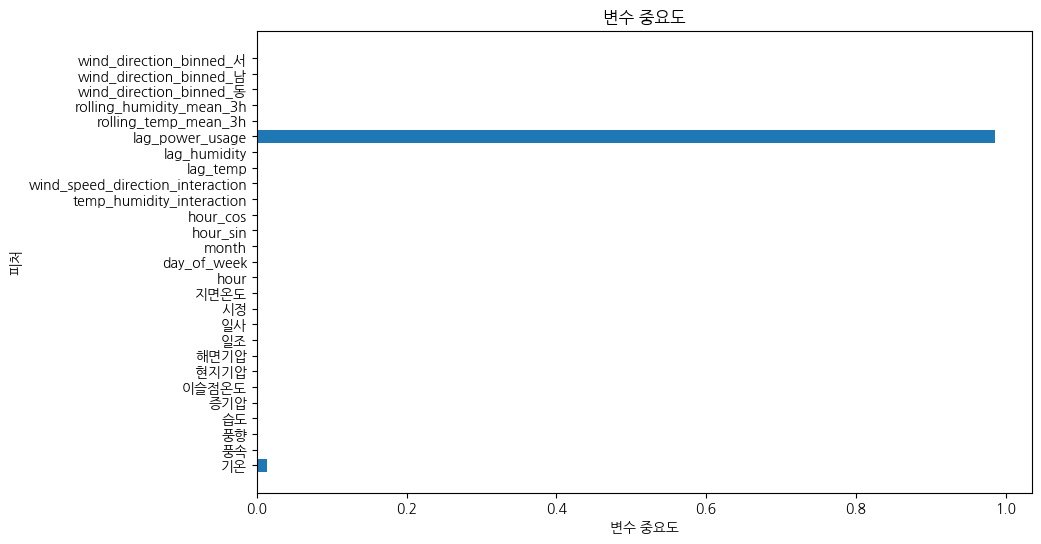

In [ ]:
# =================== 파생변수 구성 -=========

df= pd.read_csv('/mnt/data/realreal_final_df.csv', encoding='utf-8')

# 1. '시간' 컬럼을 datetime 형식으로 변환
df['시간'] = pd.to_datetime(df['시간'])

# 2. 시간 기반 피쳐 생성 (hour, 요일, 월, 계절)
df['hour'] = df['시간'].dt.hour  # 시간
df['day_of_week'] = df['시간'].dt.dayofweek  # 요일 (0=월요일, 6=일요일)
df['month'] = df['시간'].dt.month  # 월
#df['day'] = df['시간'].dt.day
#df['season'] = df['시간'].dt.month % 12 // 3 + 1  # 계절 (1=겨울, 2=봄, 3=여름, 4=가을)

# 3. 시간의 주기성을 반영한 sin/cos 변환
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)  # sin 변환
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)  # cos 변환

# 4. 상호작용 피쳐 생성 (기온 × 습도, 풍속 × 풍향)
df['temp_humidity_interaction'] = df['기온'] * df['습도']
df['wind_speed_direction_interaction'] = df['풍속'] * df['풍향']

# 5. 시차 피쳐 생성 (기온, 습도, 전력사용량의 1시간 시차)
df['lag_temp'] = df['기온'].shift(1)
df['lag_humidity'] = df['습도'].shift(1)
df['lag_power_usage'] = df['전력사용량'].shift(1)

# 6. 이동 평균 피쳐 생성 (3시간 이동 평균)
df['rolling_temp_mean_3h'] = df['기온'].rolling(window=3).mean()
df['rolling_humidity_mean_3h'] = df['습도'].rolling(window=3).mean()
# df['rolling_power_usage_mean_3h'] = df['전력사용량'].rolling(window=3).mean()

# 7. 풍향을 범주형 값으로 변환 (0-90도: N, 90-180도: E, 180-270도: S, 270-360도: W)
wind_direction_bins = [0, 90, 180, 270, 360]
wind_direction_labels = ['북', '동', '남', '서']  # 한글로 변환
df['wind_direction_binned'] = pd.cut(df['풍향'], bins=wind_direction_bins, labels=wind_direction_labels, right=False)

# 범주형 변수를 더미 변수로 변환
df = pd.get_dummies(df, columns=['wind_direction_binned'], drop_first=True)

# NaN 값 처리는 따로 하지 않고 그대로 유지

# XGBoost 모델링을 위한 데이터 준비
# 타겟 변수는 '전력사용량', 독립 변수는 나머지
X = df.drop(columns=['전력사용량', '시간'])  # 타겟 변수와 시간 제거
y = df['전력사용량']

# train/test 데이터 분할 (2021-10-30을 테스트 데이터로 사용하고 나머지 날짜를 train 데이터로 사용)
train_df = df[df['시간'] != '2021-10-30']
test_df = df[df['시간'] == '2021-10-30']

# X_train, X_test, y_train, y_test로 나누기
X_train = train_df.drop(columns=['전력사용량', '시간'])  # 타겟 변수와 시간 제거
y_train = train_df['전력사용량']

X_test = test_df.drop(columns=['전력사용량', '시간'])
y_test = test_df['전력사용량']

# SMAPE 계산 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# XGBoost 모델 생성
model = xgb.XGBRegressor(n_estimators=100, random_state=2020)

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# SMAPE 성능 평가
smape_score = smape(y_test, y_pred)

print(f"테스트 셋(2021-10-30)에 대한 SMAPE: {smape_score}")

# 변수 중요도 계산
feature_importances = model.feature_importances_

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances)
plt.title('변수 중요도')
plt.xlabel('변수 중요도')
plt.ylabel('피처')
plt.show()


# ===========================청주 예측 시각화=================================
plt.figure(figsize=(12, 6))

# 학습 데이터 시각화
plt.plot(train_df['시간'], y_train, label='Train Data', color='blue', linestyle='-', linewidth=1.5, alpha=0.7)

# 테스트 데이터 시각화
plt.scatter(test_df['시간'], y_test, label='Test Data (2021-10-30)', color='orange', s=50, alpha=0.9)
plt.plot([train_df['시간'].iloc[-1], test_df['시간'].iloc[0]], [y_train.iloc[-1], y_test.iloc[0]], linestyle='-', color='orange', alpha=0.7)  # 테스트 데이터 연결 실선 추가

# 예측 데이터 시각화
plt.plot(test_df['시간'], y_pred, label='Forecast (2021-10-30)', marker='x', linestyle='--', color='red', linewidth=2, alpha=0.9)
plt.plot([train_df['시간'].iloc[-1], test_df['시간'].iloc[0]], [y_train.iloc[-1], y_pred[0]], linestyle='--', color='red', linewidth=1, alpha=0.5)  # 예측 연결 점선 추가

# 그래프 제목에 SMAPE 추가
plt.title(f'전력 사용량 예측 (마지막 주 및 마지막 날), SMAPE = {smape_score:.5f}%', fontsize=16, fontproperties=font_prop)
plt.xlabel('날짜', fontsize=14, fontproperties=font_prop)
plt.ylabel('전력 사용량 (kWh)', fontsize=14, fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True)
plt.xticks(rotation=45, fontproperties=font_prop)
plt.tight_layout()
plt.show()
